[*********************100%***********************]  1 of 1 completed
C:\Users\Shihong Zhang\AppData\Local\Temp\ipykernel_13588\3857637572.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['Predicted_Return'] = predicted
C:\Users\Shihong Zhang\AppData\Local\Temp\ipykernel_13588\3857637572.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['Signal_BuyHold'] = 1  # Buy-and-hold always long
C:\Users\Shihong Zhang\AppData\Local\Temp\ipykernel_13588\3857637572.py:31: SettingWithCopyWarn

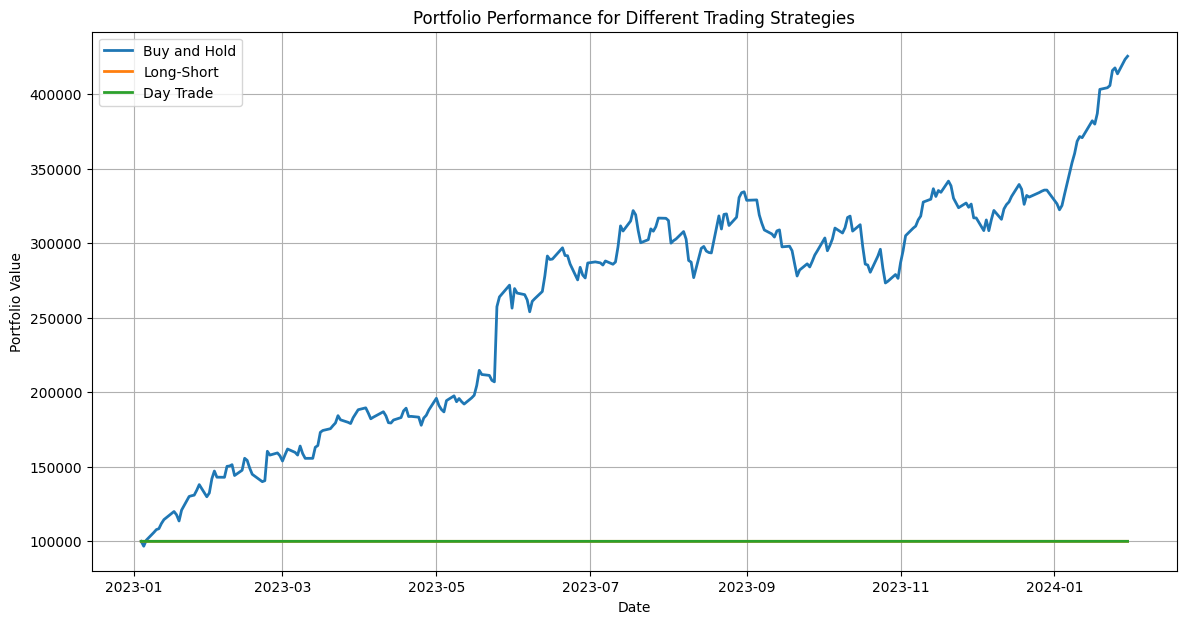

                 Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2024-01-24  60.304001  62.848999  59.938000  61.362000  61.344608  560271000   
2024-01-25  62.349998  62.719002  60.849998  61.617001  61.599529  482777000   
2024-01-26  60.959999  61.783001  60.573002  61.030998  61.013702  390309000   
2024-01-29  61.231998  62.488998  60.907001  62.465000  62.447292  348733000   
2024-01-30  62.900002  63.493000  62.259998  62.773998  62.756203  410735000   

            Predicted_Return  Signal_BuyHold  Signal_LongShort  \
Date                                                             
2024-01-24          0.070309               1                 1   
2024-01-25          0.122034               1                 1   
2024-01-26         -0.124046               1                -1   
2024-01-29         -0.011686               1                -1   
2024-01-30         -0.080940               

In [9]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf

# Load NVDA data
start_date = datetime(2023, 1, 1)
end_date = datetime(2024, 1, 31)
stock_symbol = 'NVDA'
stock = yf.download(stock_symbol, start_date, end_date)

# Define GARCH path function
def garch_path(params, Y, T):
    mu, omega, alpha, beta, mu1, sig1, mu2, sig2, p, _, _ = params  # Extra parameters ignored
    sigma2, path = {}, {}
    sigma2[0] = np.var(Y)
    path[0] = Y[0]
    for t in range(1, T):
        sigma2[t] = omega + alpha * ((Y[t - 1] - mu) ** 2) + beta * sigma2[t - 1]
        sigma2[t] = max(sigma2[t], 1e-2)
        u = np.random.uniform(0, 1)
        shock = np.random.normal(mu1, sig1) if u <= p else np.random.normal(mu2, sig2)
        path[t] = mu + np.sqrt(sigma2[t]) * shock
    return path, sigma2

# Define trading rules
def trading_rules(stock_data, predicted, threshold=0.01):
    stock_data['Predicted_Return'] = predicted
    stock_data['Signal_BuyHold'] = 1  # Buy-and-hold always long
    stock_data['Signal_LongShort'] = np.where(stock_data['Predicted_Return'] > threshold, 1, -1)
    stock_data['Signal_DayTrade'] = np.sign(stock_data['Predicted_Return'])

    initial_balance = 100000  # Starting with $100,000
    position = initial_balance / stock_data['Close'].iloc[0]

    # Portfolio calculations
    stock_data['Portfolio_BuyHold'] = position * stock_data['Close']
    stock_data['Portfolio_LongShort'] = (
        initial_balance +
        (stock_data['Signal_LongShort'].shift(1) * stock_data['Close'].diff()).fillna(0).cumsum()
    )
    stock_data['Portfolio_DayTrade'] = (
        initial_balance +
        (stock_data['Signal_DayTrade'].shift(1) * stock_data['Close'].diff()).fillna(0).cumsum()
    )
    return stock_data

# Prepare data for GARCH model
Y = np.diff(np.log(stock['Adj Close'].values))
T = len(Y)

# GARCH parameters
param_star = np.array([np.mean(Y), np.var(Y) / 1900, 0.09, 0.72, 0.02, 0.75, -0.01, 0.85, 0.35, 1.15, 0.65])
path, _ = garch_path(param_star, Y, T)
predicted_returns = np.array([path[t] for t in range(T)])

# Apply trading rules
results = trading_rules(stock.iloc[1:], predicted_returns)

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(results['Portfolio_BuyHold'], label='Buy and Hold', linewidth=2)
plt.plot(results['Portfolio_LongShort'], label='Long-Short', linewidth=2)
plt.plot(results['Portfolio_DayTrade'], label='Day Trade', linewidth=2)
plt.title('Portfolio Performance for Different Trading Strategies')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()

# Display final results
print(results.tail())
